In [ ]:
Importing Dependencies

In [1]:
import re
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

2023-02-17 16:43:57.197815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Constants

In [2]:
autotune = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
batch_size = 16
image_size = [180,180]
epochs = 25

Load Data

In [3]:
# Only 16 items in validation - we need to remake so test:val ratio is ~ 4:1.

main_path = os.path.join("chest_xray")
train_path = os.path.join(main_path, "train")
test_path = os.path.join(main_path, "test")
val_path = os.path.join(main_path, "val")

In [4]:
filenames = tf.io.gfile.glob(str(train_path + "/*/*"))
print(len(filenames))
filenames.extend(tf.io.gfile.glob(str(val_path + "/*/*")))
print(len(filenames))

5216
5232


In [5]:
from sklearn.model_selection import train_test_split

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)
test_filenames = tf.io.gfile.glob(str(test_path + "/*/*"))

In [6]:
normal_count = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f'Normal images in training set: {normal_count}')
pneumonia_count = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f'Pneumonia images in training set: {pneumonia_count}')

Normal images in training set: 1077
Pneumonia images in training set: 3108


In [7]:
# This is an imabalance - will fix later.

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
test_ds = tf.data.Dataset.from_tensor_slices(test_filenames)
val_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

2023-02-17 16:44:00.178779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
print(len(train_filenames))
print(len(val_filenames))

# Good ratio.

4185
1047


In [10]:
class_names = os.listdir(train_path)[1:]
class_names

['PNEUMONIA', 'NORMAL']

In [11]:
# Mapping labels to images.

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # Returns True for Pneumonia and False for Normal.
    return parts[-2] == "PNEUMONIA"

In [12]:
def decode_image(image):
    # Convert to 3D unit8 tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Scale values from [0,1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize image
    return tf.image.resize(image, image_size)

In [13]:
def process_path(file_path):
    label = get_label(file_path)
    # Load raw data from file as a string
    image = tf.io.read_file(file_path)
    image = decode_image(image)
    return image, label

In [14]:
train_data = train_ds.map(process_path, num_parallel_calls=autotune)

test_data = test_ds.map(process_path, num_parallel_calls=autotune)
test_data = test_data.batch(batch_size)

val_data = val_ds.map(process_path, num_parallel_calls=autotune)

In [20]:
for image, label in train_data.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


Visualize Dataset

In [21]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
            
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    
    ds = ds.repeat()
    
    ds = ds.batch(batch_size)
    
    ds = ds.prefetch(buffer_size=autotune)
    
    return ds

In [22]:
# Call next iteration of training data.

train_data = prepare_for_training(train_data)
val_data = prepare_for_training(val_data)

image_batch, label_batch = next(iter(train_data))

2023-02-17 16:53:50.476973: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [25]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20,18))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

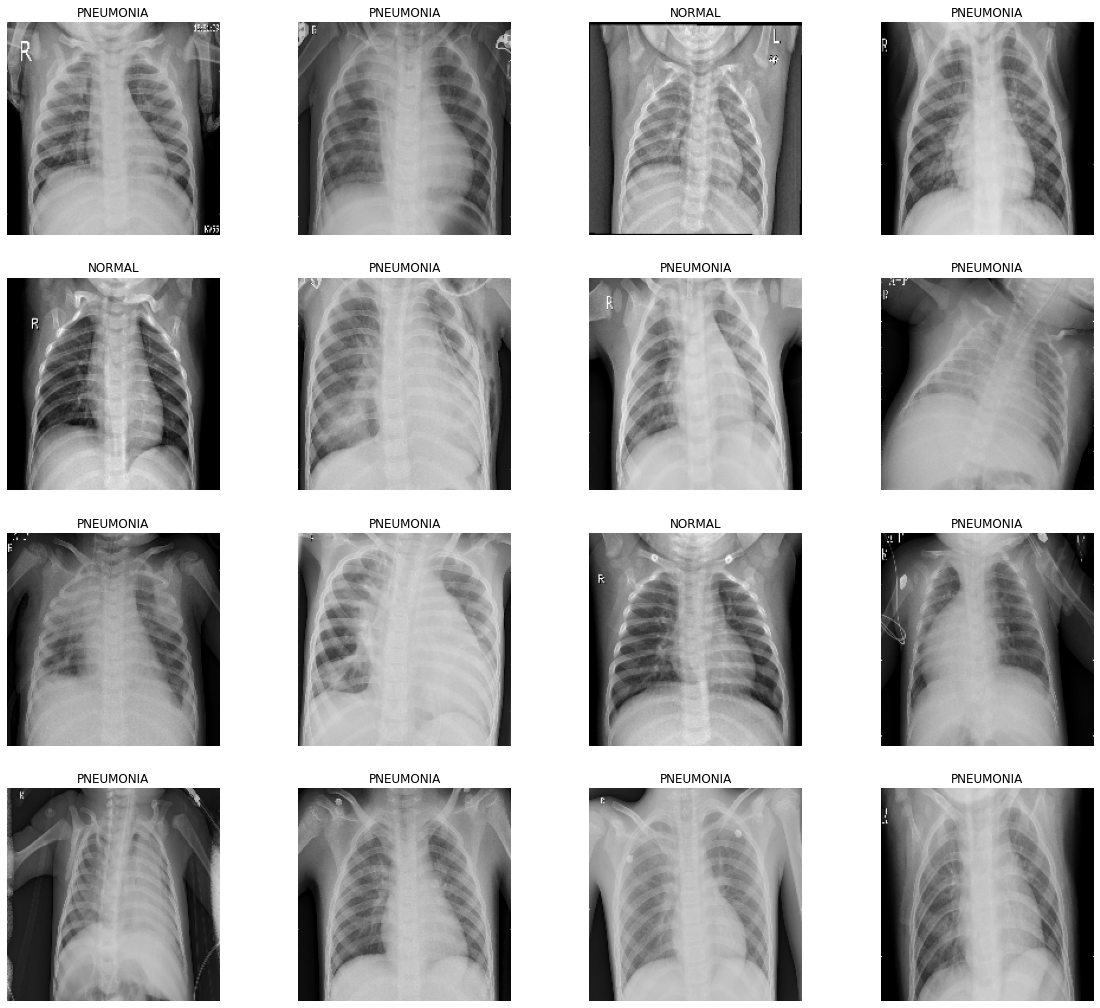

In [26]:
show_batch(image_batch.numpy(), label_batch.numpy())

Build CNN

In [27]:
from keras.models import Sequential
from keras.layers import SeparableConv2D, BatchNormalization, Dropout, MaxPool2D, Dense, Input, Conv2D, Flatten

In [28]:
def conv_block(filters):
    block = Sequential([
        SeparableConv2D(filters, 3, activation="relu", padding="same"),
        SeparableConv2D(filters, 3, activation="relu", padding="same"),
        BatchNormalization(),
        MaxPool2D()
    ])
    
    return block

In [29]:
def dense_block(units, dropout_rate):
    block = Sequential([
        Dense(units, activation="relu"),
        BatchNormalization(),
        Dropout(dropout_rate)
    ])
    
    return block

In [30]:
def build_model():
    model = Sequential([
        Input(shape=(image_size[0], image_size[1], 3)),
        
        Conv2D(16, 3, activation="relu", padding="same"),
        Conv2D(16, 3, activation="relu", padding="same"),
        MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        Dropout(0.2),
        
        conv_block(256),
        Dropout(0.2),
        
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        Dense(1, activation="sigmoid")
    ])
    
    return model

In [31]:
initial_bias = np.log([pneumonia_count/normal_count])
initial_bias

array([1.05980003])

In [33]:
weight_for_0 = (1 / normal_count)*(len(train_ds))/2.0 
weight_for_1 = (1 / pneumonia_count)*(len(train_ds))/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [34]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [35]:
history = model.fit(
    train_data,
    steps_per_epoch=len(train_ds) // batch_size,
    epochs=epochs,
    validation_data=val_data,
    validation_steps=len(val_ds) // batch_size,
    class_weight=class_weight,
)

Epoch 1/25
261/261 [==============================] - 79s 279ms/step - loss: 0.3619 - accuracy: 0.8156 - precision: 0.9594 - recall: 0.7850 - val_loss: 0.6192 - val_accuracy: 0.7404 - val_precision: 0.7404 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 70s 267ms/step - loss: 0.2326 - accuracy: 0.9045 - precision: 0.9757 - recall: 0.8936 - val_loss: 1.7542 - val_accuracy: 0.7394 - val_precision: 0.7394 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 71s 273ms/step - loss: 0.1999 - accuracy: 0.9224 - precision: 0.9757 - recall: 0.9184 - val_loss: 0.1945 - val_accuracy: 0.9212 - val_precision: 0.9957 - val_recall: 0.8975
Epoch 4/25
261/261 [==============================] - 72s 276ms/step - loss: 0.1876 - accuracy: 0.9334 - precision: 0.9777 - recall: 0.9317 - val_loss: 0.1010 - val_accuracy: 0.9606 - val_precision: 0.9790 - val_recall: 0.9676
Epoch 5/25
261/261 [==============================] - 75s 288ms/step - loss: 0.1656 - accura

Finetuning Model

In [38]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

In [39]:
checkpoint_cb = ModelCheckpoint("xray_model.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

In [41]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = LearningRateScheduler(exponential_decay_fn)

In [42]:
history = model.fit(
    train_data,
    steps_per_epoch=len(train_ds) // batch_size,
    epochs=100,
    validation_data=val_data,
    validation_steps=len(val_ds) // batch_size,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/100
261/261 [==============================] - 65s 248ms/step - loss: 0.5144 - accuracy: 0.7519 - precision: 0.9057 - recall: 0.7433 - val_loss: 0.4368 - val_accuracy: 0.7692 - val_precision: 0.7636 - val_recall: 0.9987 - lr: 0.0100
Epoch 2/100
261/261 [==============================] - 68s 263ms/step - loss: 0.3464 - accuracy: 0.8580 - precision: 0.9454 - recall: 0.8586 - val_loss: 0.3292 - val_accuracy: 0.8673 - val_precision: 0.8786 - val_recall: 0.9518 - lr: 0.0089
Epoch 3/100
261/261 [==============================] - 71s 270ms/step - loss: 0.3105 - accuracy: 0.8611 - precision: 0.9539 - recall: 0.8541 - val_loss: 0.2243 - val_accuracy: 0.9077 - val_precision: 0.9409 - val_recall: 0.9336 - lr: 0.0079
Epoch 4/100
261/261 [==============================] - 71s 270ms/step - loss: 0.2599 - accuracy: 0.8891 - precision: 0.9678 - recall: 0.8801 - val_loss: 0.1751 - val_accuracy: 0.9365 - val_precision: 0.9424 - val_recall: 0.9741 - lr: 0.0071
Epoch 5/100
261/261 [===============

In [43]:
history.history

{'loss': [0.5143704414367676,
  0.34635499119758606,
  0.31049811840057373,
  0.2598749101161957,
  0.23212303221225739,
  0.22814907133579254,
  0.20434688031673431,
  0.19924405217170715,
  0.16435614228248596,
  0.17083202302455902,
  0.1641007512807846,
  0.15659797191619873,
  0.16153164207935333,
  0.15694791078567505,
  0.1382656991481781,
  0.13796384632587433,
  0.12229973077774048,
  0.1310228705406189,
  0.11561316251754761,
  0.10568436980247498,
  0.09554727375507355,
  0.08934337645769119,
  0.09481543302536011,
  0.09914392977952957,
  0.09304934740066528,
  0.08718910813331604,
  0.08945972472429276,
  0.08489704132080078,
  0.08407370746135712,
  0.0782332718372345,
  0.06818310916423798,
  0.07730542868375778,
  0.07699215412139893,
  0.07782819867134094,
  0.07400213181972504,
  0.06222229450941086,
  0.061090607196092606,
  0.06630869209766388,
  0.063711978495121,
  0.05893188714981079,
  0.06538461893796921,
  0.06156110391020775,
  0.05744752660393715,
  0.060948

Visualizing Metrics

In [44]:
def plot(metric=str):
    plt.figure(figsize=(8,6))
    
    plt.plot(history.history[metric], color="teal", label=metric)
    plt.plot(history.history["val_" + metric], color="orange", label="val " + metric)
    plt.title(metric)
    plt.legend(loc="upper left")
    
    plt.show()

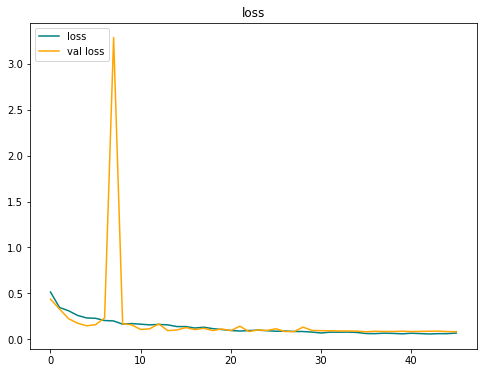

In [45]:
plot("loss")

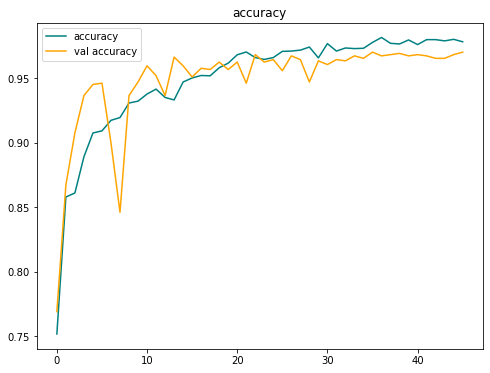

In [46]:
plot("accuracy")

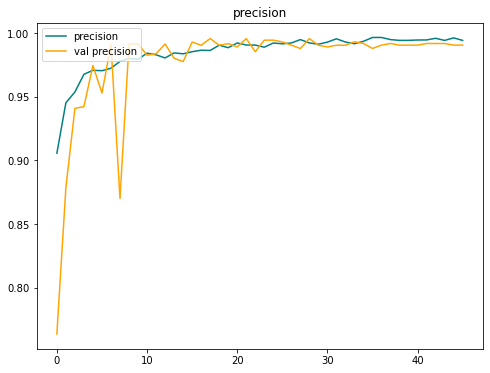

In [47]:
plot("precision")

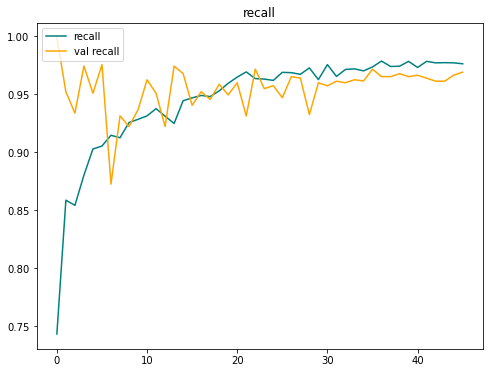

In [48]:
plot("recall")

Predicting & Evaluating

In [49]:
loss, acc, prec, rec = model.evaluate(test_data)

39/39 [==============================] - 4s 88ms/step - loss: 0.9924 - accuracy: 0.8061 - precision: 0.7706 - recall: 0.9821


In [52]:
print(f'Loss: {loss}\nAccuracy: {acc}\nPrecision: {prec}\nRecall: {rec}')

Loss: 0.992394745349884
Accuracy: 0.8060897588729858
Precision: 0.7706237435340881
Recall: 0.9820512533187866


In [54]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 45, 45, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       27072     
                                                      

In [61]:
import random

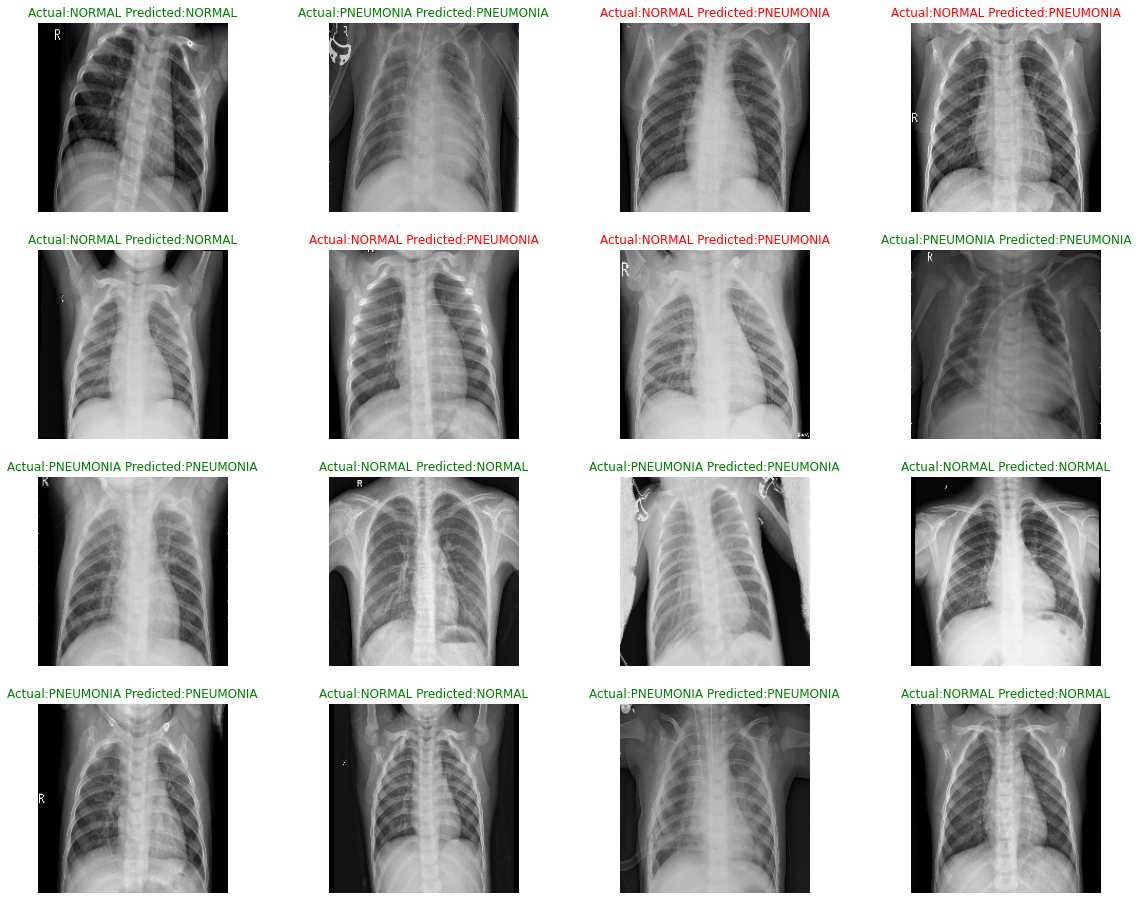

In [106]:
plt.figure(figsize=(20,16))
for idx in range(16):
    class_name = random.choice(class_names)
    
    while True:
        filename = random.choice(os.listdir(test_path + "/" + class_name))
        if filename != '.DS_Store': break
    filepath = test_path + "/" + class_name + "/" + filename
#    print(filepath)
    
    image, label = process_path(filepath)
#    print(image.shape)
#    print(label)

    pred_prob = model.predict(tf.expand_dims(image, axis=0), verbose=0)
    
    
    pred = 0 if pred_prob[0][0] > 0.5 else 1 
    pred_class = class_names[pred] 
    # We made 'pneumonia = 1'.

    plt.subplot(4, 4, idx+1)
    plt.imshow(image)
    if class_name == pred_class:
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"Actual:{class_name} Predicted:{pred_class}", c=title_color)
    plt.axis(False)